```@meta
CurrentModule = AlgorithmicRecourse 
```

# From cat to dog

In [1]:
using Plots, AlgorithmicRecourse, Random
using Logging
disable_logging(Logging.Info)

┌ Warning: Package AlgorithmicRecourse does not have BSON in its dependencies:
│ - If you have AlgorithmicRecourse checked out for development and have
│   added BSON as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with AlgorithmicRecourse
└ Loading BSON into AlgorithmicRecourse from project dependency, future warnings for AlgorithmicRecourse are suppressed.


LogLevel(1)

In [2]:
retrain = false
include("CIFAR10.jl")
# Load model
n_epochs = 200
BSON.@load "data/CIFAR10_nn_" * string(n_epochs) * ".bson" nn
println("Training accuracy: " * string(accuracy(train_x, train_y)))
println("Validation accuracy: " * string(accuracy(val_x, val_y)))

Training accuracy: 0.8024444444444444


Validation accuracy: 0.716


In [3]:
using AlgorithmicRecourse, AlgorithmicRecourse.Models
import AlgorithmicRecourse.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.FittedModel
    nn::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.nn(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= σ.(logits(𝑴, X))
𝑴 = NeuralNetwork(nn);

In [4]:
ŷ = vec(round.(probs(𝑴, train_x))) # predicted class
# ŷ = CIFAR10.trainlabels()[1:1000]
cats = findall(ŷ .== 0)
dogs = findall(ŷ .== 1)
# Plot random samples:
using Plots
Random.seed!(123)
n_samples = 10
using StatsBase
random_cats = sample(cats, n_samples, replace=false)
random_dogs = sample(dogs, n_samples, replace=false)
conv2image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))
p_list = [plot(conv2image(train_x[:,:,:,i]), size=(100,100), axis=nothing, title=ifelse(train_y[i]==ŷ[i],"Correct","Wrong")) for i ∈ vcat(random_cats, random_dogs)];

In [5]:
plt = plot(p_list...,layout=(2,n_samples), size=(1000,200))
savefig(plt, "www/CIFAR10_predictions.png")

![](www/CIFAR10_predictions.png)

In [6]:
using Images, FileIO
sad_cat = load("www/cat.png")
happy_dog = load("www/dog.png");

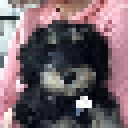

In [7]:
using ImageTransformations
ratio = 32/size(happy_dog)[1]
happy_dog = imresize(happy_dog, ratio=ratio)

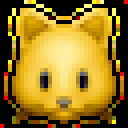

In [8]:
cat_rgb = RGB.(sad_cat)

In [9]:
cat_CHW = channelview(cat_rgb);
cat_WHC = permutedims(cat_CHW, (3,2,1))
cat_train = reshape(cat_CHW, (size(cat_WHC)...,1))
cat_train = convert(Array{Float32},cat_train)
probs(𝑴,cat_train)

1×1 Matrix{Float32}:
 0.6517574

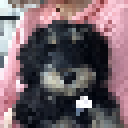

In [10]:
dog_rgb = RGB.(happy_dog)

In [11]:
dog_CHW = channelview(dog_rgb);
dog_WHC = permutedims(dog_CHW, (3,2,1))
dog_train = reshape(dog_CHW, (size(dog_WHC)...,1))
# dog_train = convert(Array{Float32},dog_train)
probs(𝑴,dog_train)

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = N0f8
│   T2 = Float32
└ @ NNlib /Users/FA31DU/.julia/packages/NNlib/nYCKa/src/conv.jl:288


1×1 Matrix{Float32}:
 0.53444034

## Recourse

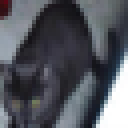

In [13]:
chosen_sample = train_x[:,:,:,random_cats[1]]
x̅ = reshape(chosen_sample,(size(chosen_sample)...,1))
conv2image(x̅[:,:,:,1])

In [14]:
y̅ = round(probs(𝑴, x̅)[1])
target = 1.0
γ = 0.95; # desired level of confidence

In [15]:
generator = GenericGenerator(1,1,1e-5,:logitbinarycrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ, feasible_range=(0.0,1.0)); # generate recourse

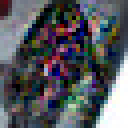

In [16]:
conv2image(recourse.x̲[:,:,:,1])

### Greedy

In [21]:
generator = GreedyGenerator(0.25,20,:logitbinarycrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ,feasible_range=(0.0,1.0)); # generate recourse

┌ Warning: Slow fallback implementation invoked for ∇conv_data!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float64
│   T2 = Float32
└ @ NNlib /Users/FA31DU/.julia/packages/NNlib/nYCKa/src/conv.jl:288


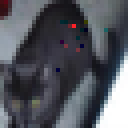

In [22]:
conv2image(recourse.x̲[:,:,:,1])